In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for our plots
sns.set_context("notebook", font_scale=1.5)

# no grid, just white

# Authenticate and initialize wandb
api = wandb.Api()

# Fetch the specific run
run = api.run("aneeshers_research/early-stop-finetuner/4d53zqej")

# Get run summary (final metrics)
summary = run.summary._json_dict
print("Run Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

# Get run history (metrics over time)
history = run.scan_history()
history_df = pd.DataFrame(history)

# Display information about the available columns
print("\nAvailable metrics for plotting:")
for col in history_df.columns:
    print(f"- {col}")

Run Summary:
_runtime: 1252.8951227664948
_step: 56
_timestamp: 1745682921.6946778
_wandb: {'runtime': 1265}
eval/loss: 0.0801929458975792
eval/mse: 0.0801929458975792
eval/pearsonr: 0.4434060177179938
eval/runtime: 11.0683
eval/samples_per_second: 116.91
eval/steps_per_second: 14.636
total_flos: 0
train/epoch: 10
train/global_step: 2330
train/grad_norm: 0.1254296749830246
train/learning_rate: 1.3304721030042918e-06
train/loss: 0.0843
train_loss: 0.08501771089856716
train_runtime: 1218.2323
train_samples_per_second: 61.154
train_steps_per_second: 1.913

Available metrics for plotting:
- _timestamp
- eval/samples_per_second
- _step
- eval/mse
- train/epoch
- eval/pearsonr
- eval/runtime
- train/global_step
- eval/steps_per_second
- _runtime
- train/loss
- train/grad_norm
- train/learning_rate
- eval/loss


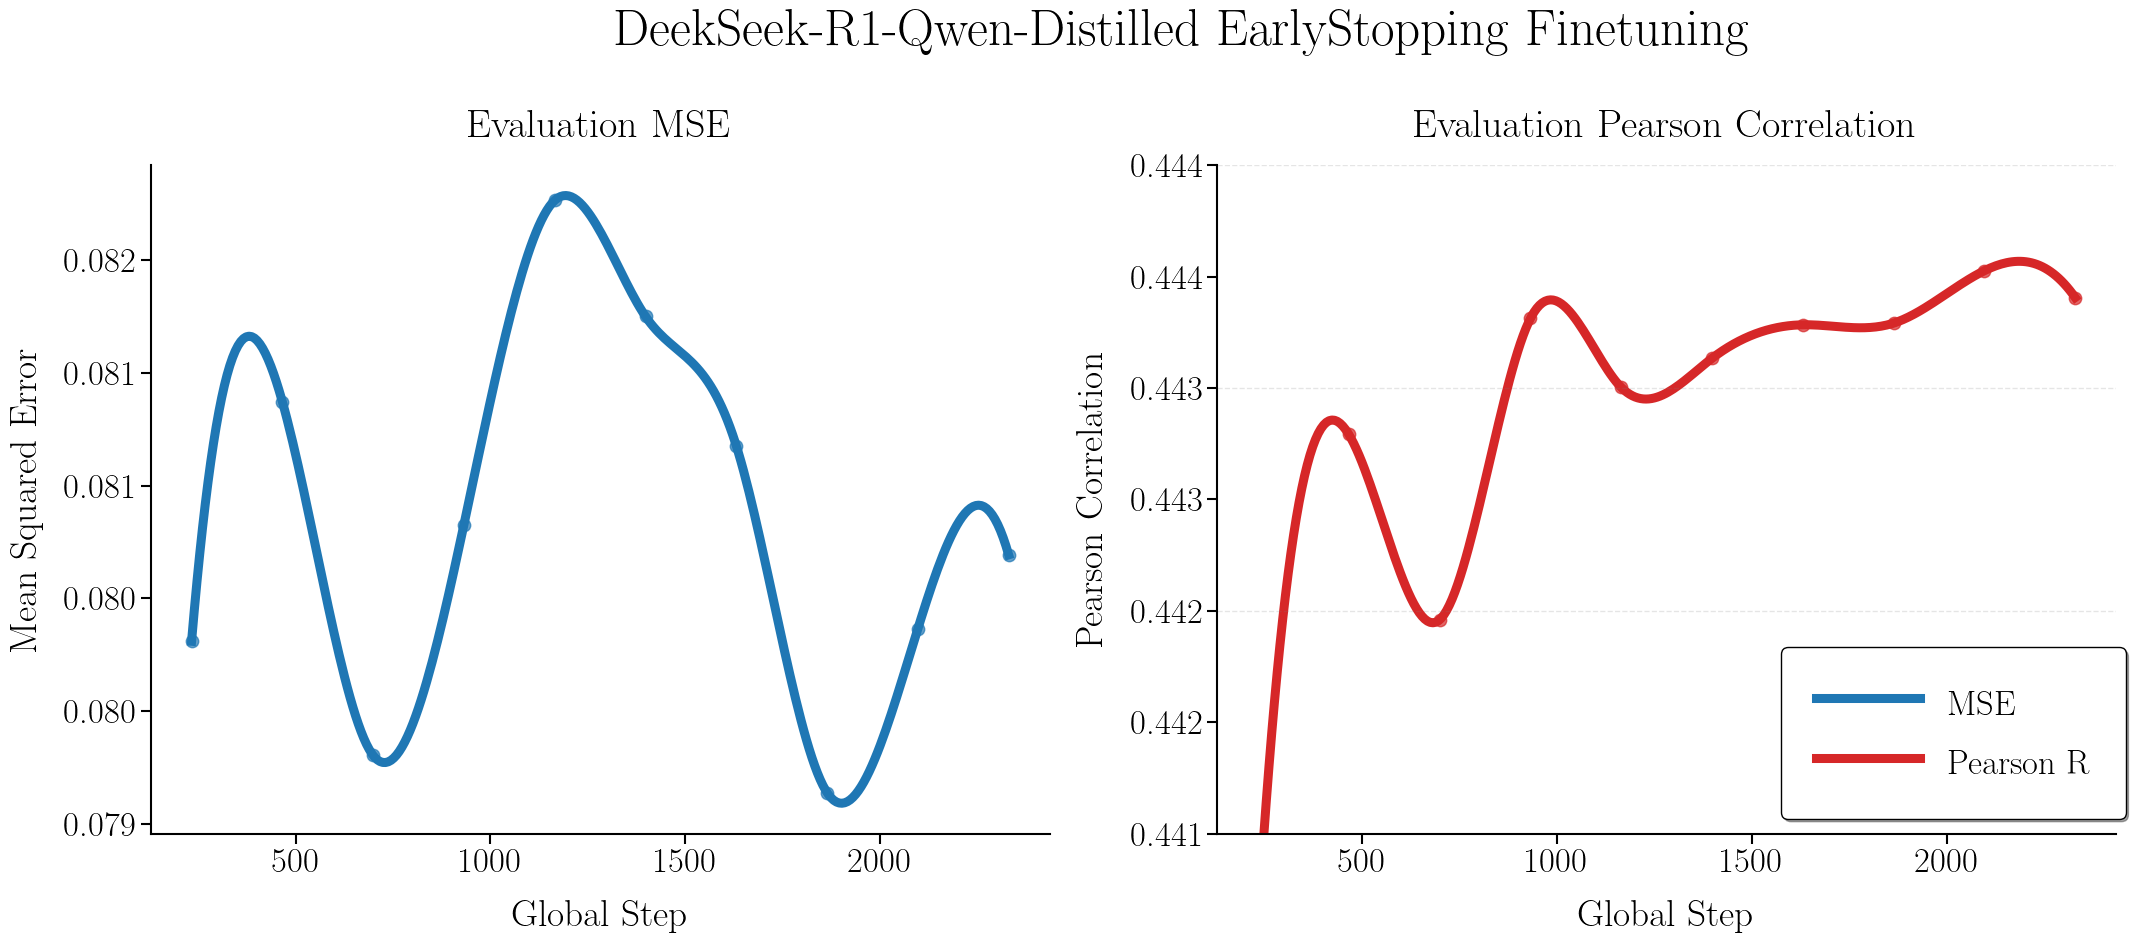

Plot saved as 'figures/deekseek_finetuning_earlystop.pdf'
Number of evaluation points: 10


In [10]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
import os

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Check for LaTeX and configure path if available
if os.path.exists("/Library/TeX/texbin/latex"):
    latex_path = "/Library/TeX/texbin/latex"
    latex_dir = os.path.dirname(latex_path)
    os.environ['PATH'] = os.environ['PATH'] + os.pathsep + latex_dir

# Font size controls - easily adjustable
PLUS = 7  # Increase this value to make all text larger
TITLE_SIZE = 26 + PLUS
SUBTITLE_SIZE = 22 + PLUS
LABEL_SIZE = 20 + PLUS
TICK_SIZE = 18 + PLUS
TEXT_SIZE = 18 + PLUS
LEGEND_SIZE = 18 + PLUS
EQUATION_SIZE = 18 + PLUS
NOTE_SIZE = 18 + PLUS

# Line styling parameters
LINE_WIDTH = 6.5  # Thicker lines
MARKER_SIZE = 10  # Larger markers
SCATTER_SIZE = 80  # Size of scatter points
SCATTER_ALPHA = 0.7  # Transparency of scatter points
SMOOTHING_POINTS = 300  # Number of points for smooth curve
SPLINE_DEGREE = 3  # Degree of spline interpolation (1=linear, 3=cubic)

# Colors - using a more professional color palette
COLORS = {
    'mse': '#1f77b4',  # Blue
    'pearson': '#d62728'  # Red
}

# Configure matplotlib with LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": LABEL_SIZE,
    "axes.titlesize": SUBTITLE_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "text.latex.preamble": r'\usepackage{amsmath} \usepackage{amssymb}',
    "axes.linewidth": 1.5,  # Thicker axis lines
    "xtick.major.width": 1.5,  # Thicker tick marks
    "ytick.major.width": 1.5,
    "xtick.major.size": 7,  # Longer tick marks
    "ytick.major.size": 7,
    "axes.spines.top": False,  # Remove top spine for cleaner look
    "axes.spines.right": False,  # Remove right spine for cleaner look
})

# Function to create smooth line
def plot_smooth_line(ax, x, y, color, label):
    # Remove NaN values
    mask = ~np.isnan(y)
    x_clean = x[mask]
    y_clean = y[mask]
    
    if len(x_clean) > SPLINE_DEGREE:  # Need at least SPLINE_DEGREE+1 points for spline
        # Create smooth line with more points
        x_smooth = np.linspace(min(x_clean), max(x_clean), SMOOTHING_POINTS)
        spl = make_interp_spline(x_clean, y_clean, k=SPLINE_DEGREE)
        y_smooth = spl(x_smooth)
        
        # Plot the smooth line
        ax.plot(x_smooth, y_smooth, color=color, linewidth=LINE_WIDTH, label=label)
        # Plot original data points
        ax.scatter(x_clean, y_clean, color=color, s=SCATTER_SIZE, alpha=SCATTER_ALPHA)
    else:
        # Not enough points for spline, use regular line
        ax.plot(x_clean, y_clean, color=color, linewidth=LINE_WIDTH, label=label)
        ax.scatter(x_clean, y_clean, color=color, s=SCATTER_SIZE)

# Create a figure with two subplots side by side with more space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# Function to style each axis consistently
def style_axis(ax, title, y_label, y_formatter='%.3f'):
    # Set titles and labels
    ax.set_title(title, pad=20)  # Add padding for title
    ax.set_xlabel(r'Global Step', labelpad=15)  # Add padding for xlabel
    ax.set_ylabel(y_label, labelpad=15)  # Add padding for ylabel
    
    # Turn off grid
    ax.grid(False)
    
    # Format y-axis to show fewer decimal places
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter(y_formatter))
    
    # Add thin horizontal reference lines for the Pearson plot
    if 'Pearson' in y_label:
        # Add reference lines at key values within the narrow range
        for ref_value in [0.441, 0.442, 0.443, 0.444]:
            ax.axhline(y=ref_value, color='gray', linestyle='--', alpha=0.2, linewidth=1)

# Plot eval/mse on the first subplot
if 'eval/mse' in history_df.columns and 'train/global_step' in history_df.columns:
    plot_smooth_line(
        ax1, 
        history_df['train/global_step'].values, 
        history_df['eval/mse'].values, 
        COLORS['mse'], 
        'MSE'
    )
    style_axis(ax1, r'Evaluation MSE', r'Mean Squared Error')

# Plot eval/pearsonr on the second subplot
if 'eval/pearsonr' in history_df.columns and 'train/global_step' in history_df.columns:
    plot_smooth_line(
        ax2, 
        history_df['train/global_step'].values, 
        history_df['eval/pearsonr'].values, 
        COLORS['pearson'], 
        'Pearson R'
    )
    style_axis(ax2, r'Evaluation Pearson Correlation', r'Pearson Correlation')
    
    # Set specific y-axis limits for the Pearson plot
    ax2.set_ylim(0.441, 0.444)

# Create a single legend outside of the plots if needed
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Ensure each subplot has a legend before trying to remove it
for ax in [ax1, ax2]:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Add the legend to the figure (outside the plots)
legend = fig.legend(
    handles1 + handles2,
    labels1 + labels2,
    bbox_to_anchor=(0.9, 0.33),
    frameon=True,
    fancybox=True,
    framealpha=1,
    shadow=True,
    borderpad=1,
    handlelength=3,
    handleheight=1.5,
    fontsize=LEGEND_SIZE
)
legend.get_frame().set_edgecolor('black')

# Add a super title
fig.suptitle(r'DeekSeek-R1-Qwen-Distilled EarlyStopping Finetuning', 
             fontsize=TITLE_SIZE + 4, y=0.95)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust rect to make room for the legend and super title

# Save the figure
plt.savefig('figures/deekseek_finetuning_earlystop.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'figures/deekseek_finetuning_earlystop.pdf'")
print(f"Number of evaluation points: {len(history_df['eval/mse'].dropna())}")